In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from esn_lib.esn import *
from esn_lib.hubesn import *
from esn_tasks.mackey_glass.mackey import *

In [2]:
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

EXPTPATH = f"../results/info_propagation/peak_res_time_{params['input_neurons']}"
PLTPATH = f'../plots/info_propagation'

task_pm = {
    'n_train': 2000,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

NameError: name 'MackeyGlass' is not defined

In [81]:
def get_peak_time(array):
    diff = array[1:] - array[:-1]
    state_peak = []
    for i in range(diff.shape[1]):
        state_peak.append(np.where(np.diff(np.sign(diff[:, i])))[0] + 1)
    return state_peak

def get_peak_delay_count(inputs, states):
    in_peak = get_peak_time(inputs)[0]
    state_peak = get_peak_time(states)

    # each row of state_peak is the peak time of a neuron, however, some neuron may not have a peak when the input has a peak
    # so we need to find the closest peak time of the input for each neuron, the closest peak time is the largest peak time that is smaller than the neuron's peak time
    n_peaks = in_peak.shape[0]
    peak_delay = np.zeros((len(state_peak), 1))
    missed_peak_count = np.zeros((len(state_peak), 1))
    for i in range(len(state_peak)):
        closest_peak = []
        if state_peak[i].shape[0] > n_peaks:
            short_peak = in_peak
            long_peak = state_peak[i]
        else:
            short_peak = state_peak[i]
            long_peak = in_peak
        for j in range(short_peak.shape[0]):
            cp = long_peak[long_peak < short_peak[j]]
            if cp.shape[0] == 0:
                closest_peak.append(0)
            else:
                closest_peak.append(cp[-1])

        peak_delay[i] = np.mean(short_peak - closest_peak)
        missed_peak_count[i] = np.abs(n_peaks - state_peak[i].shape[0])
    
    return peak_delay, missed_peak_count

In [82]:
def interate_delay_count(model, repeat=30):    
    in_count, out_count = [], []
    in_delay, out_delay = [], []
    for _ in range(repeat):
        esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
        states = esn.run(mg.X_train)
        in_states = states[:, esn.in_idx]
        out_states = states[:, esn.out_idx]
        delay, count = get_peak_delay_count(mg.X_train, in_states)
        in_count.append(count)
        in_delay.append(delay)
        delay, count = get_peak_delay_count(mg.X_train, out_states)
        out_count.append(count)
        out_delay.append(delay)
    in_count = np.concatenate(in_count, axis=1).reshape(-1)
    out_count = np.concatenate(out_count, axis=1).reshape(-1)
    in_delay = np.concatenate(in_delay, axis=1).reshape(-1)
    out_delay = np.concatenate(out_delay, axis=1).reshape(-1)

    return in_count, out_count, in_delay, out_delay

In [83]:
esn_model = 'hubesn'
repeat = 100
in_count, out_count, in_delay, out_delay = interate_delay_count(esn_model, repeat=repeat)
np.save(f'{EXPTPATH}/{esn_model}_in_count.npy', in_count)
np.save(f'{EXPTPATH}/{esn_model}_out_count.npy', out_count)
np.save(f'{EXPTPATH}/{esn_model}_in_delay.npy', in_delay)
np.save(f'{EXPTPATH}/{esn_model}_out_delay.npy', out_delay)

esn_model = 'esn'
in_count, out_count, in_delay, out_delay = interate_delay_count(esn_model, repeat=repeat)
np.save(f'{EXPTPATH}/{esn_model}_in_count.npy', in_count)
np.save(f'{EXPTPATH}/{esn_model}_out_count.npy', out_count)
np.save(f'{EXPTPATH}/{esn_model}_in_delay.npy', in_delay)
np.save(f'{EXPTPATH}/{esn_model}_out_delay.npy', out_delay)

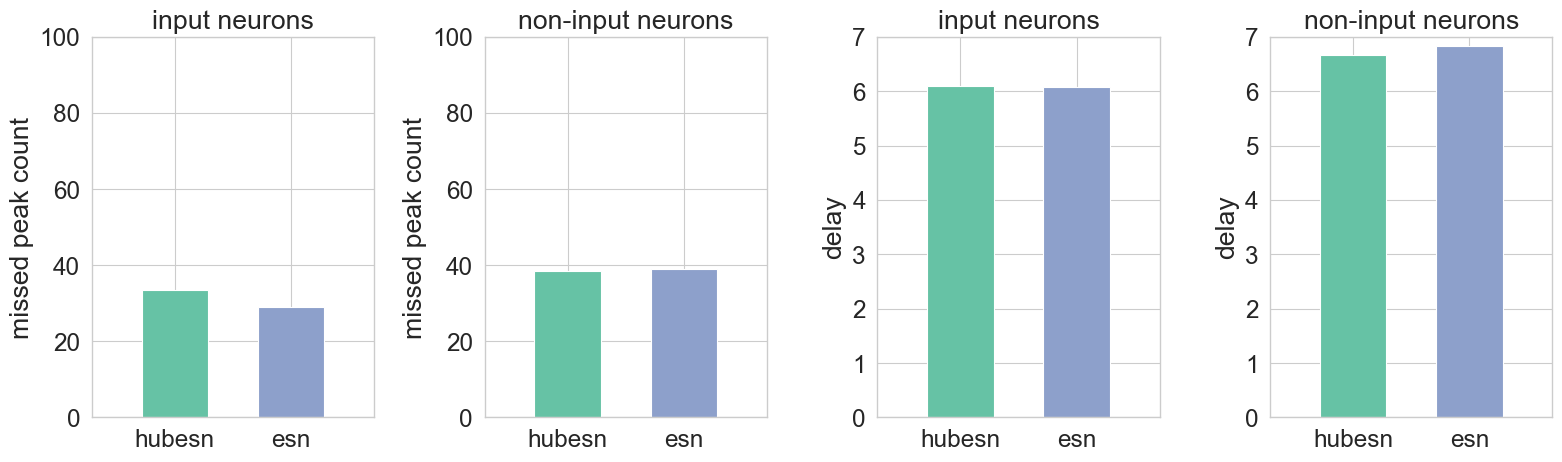

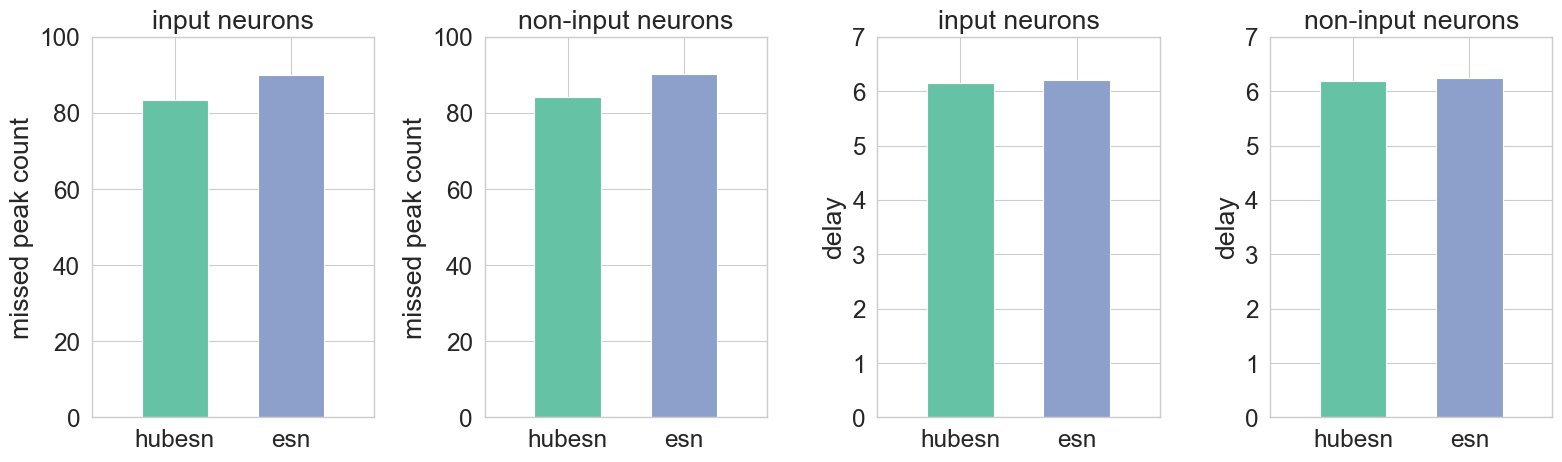

In [84]:
def plot_delay_count(mode, y_lim_count, y_lim_delay, bar_width=0.4, show_err=False):
    exptpath = f"../results/info_propagation/peak_res_time_{mode}"
    hubesn_in_count = np.load(f'{exptpath}/hubesn_in_count.npy')
    hubesn_out_count = np.load(f'{exptpath}/hubesn_out_count.npy')
    hubesn_in_delay = np.load(f'{exptpath}/hubesn_in_delay.npy')
    hubesn_out_delay = np.load(f'{exptpath}/hubesn_out_delay.npy')
    esn_in_count = np.load(f'{exptpath}/esn_in_count.npy')
    esn_out_count = np.load(f'{exptpath}/esn_out_count.npy')
    esn_in_delay = np.load(f'{exptpath}/esn_in_delay.npy')
    esn_out_delay = np.load(f'{exptpath}/esn_out_delay.npy')

    # begin plotting
    xs = [0.5, 1.2]
    xlim = [0, 1.7]
    colors = sns.color_palette("Set2")
    bar_color = [colors[0], colors[2]]
    font_scale = 2
    sns.set_style('whitegrid')
    sns.set_color_codes("bright")
    sns.set_context('paper', font_scale=font_scale)
    fig, ax = plt.subplots(1, 4, figsize=(16, 5))
    if show_err:
        ax[0].bar(xs, [np.mean(hubesn_in_count), np.mean(esn_in_count)], yerr=[np.std(hubesn_in_count), np.std(esn_in_count)], width=bar_width, color=bar_color)
        ax[1].bar(xs, [np.mean(hubesn_out_count), np.mean(esn_out_count)], yerr=[np.std(hubesn_out_count), np.std(esn_out_count)], width=bar_width, color=bar_color)
        ax[2].bar(xs, [np.mean(hubesn_in_delay), np.mean(esn_in_delay)], yerr=[np.std(hubesn_in_delay), np.std(esn_in_delay)], width=bar_width, color=bar_color)
        ax[3].bar(xs, [np.mean(hubesn_out_delay), np.mean(esn_out_delay)], yerr=[np.std(hubesn_out_delay), np.std(esn_out_delay)], width=bar_width, color=bar_color)
    else:
        ax[0].bar(xs, [np.mean(hubesn_in_count), np.mean(esn_in_count)], width=bar_width, color=bar_color)
        ax[1].bar(xs, [np.mean(hubesn_out_count), np.mean(esn_out_count)], width=bar_width, color=bar_color)
        ax[2].bar(xs, [np.mean(hubesn_in_delay), np.mean(esn_in_delay)], width=bar_width, color=bar_color)
        ax[3].bar(xs, [np.mean(hubesn_out_delay), np.mean(esn_out_delay)], width=bar_width, color=bar_color)
    
    for i in range(4):
        ax[i].set_xticks(xs)
        ax[i].set_xlim(xlim)
        ax[i].set_xticklabels(['hubesn', 'esn'])
    
    ax[0].set_ylim(y_lim_count)
    ax[1].set_ylim(y_lim_count)
    ax[2].set_ylim(y_lim_delay)
    ax[3].set_ylim(y_lim_delay)
    ax[0].set_title('input neurons')
    ax[1].set_title('non-input neurons')
    ax[2].set_title('input neurons')
    ax[3].set_title('non-input neurons')
    ax[0].set_ylabel('missed peak count')
    ax[1].set_ylabel('missed peak count')
    ax[2].set_ylabel('delay')
    ax[3].set_ylabel('delay')
    plt.tight_layout()
    plt.savefig(f'{PLTPATH}/res_time_{mode}.jpg', bbox_inches='tight')
    plt.show()

plot_delay_count('hub', [0, 100], [0, 7], show_err=False)
plot_delay_count('peri', [0, 100], [0, 7], show_err=False)

## Dimensionality Reduction Proof

In [29]:
# def plot_PCA(esn_in_states, esn_nonin_states, hub_in_states, hub_nonin_states, esn_pm, display='2d'):
#     lw = 2
#     alpha = 1
#     # plot 2D PCA
#     sns.set_style('white')
#     sns.set_context('paper', font_scale=2.5)
#     sns.set_color_codes("bright")
#     colors = sns.color_palette("Set3")
#     if display == '2d':
#         fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#         axs[0].plot(esn_in_states[:, 0], esn_in_states[:, 1], alpha=alpha, lw=lw, c=colors[4], label='input')
#         axs[0].plot(esn_nonin_states[:, 0], esn_nonin_states[:, 1], alpha=alpha, lw=lw, c=colors[5], label='non-input')
#         axs[0].set_title(f"ESN-{esn_pm['input_neurons']}")
#         axs[1].plot(hub_in_states[:, 0], hub_in_states[:, 1], alpha=alpha, lw=lw, c=colors[4], label='input')
#         axs[1].plot(hub_nonin_states[:, 0], hub_nonin_states[:, 1], alpha=alpha, lw=lw, c=colors[5], label='non-input')
#         axs[1].set_title(f"HubESN-{esn_pm['input_neurons']}")
#         for ax in axs:
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.legend()
#     else:
#         fig = plt.figure(figsize=(12, 6))
#         ax = fig.add_subplot(121, projection='3d')
#         ax.plot(esn_in_states[:, 0], esn_in_states[:, 1], esn_in_states[:, 2], color=colors[4], alpha=alpha, lw=lw, label='input')
#         ax.plot(esn_nonin_states[:, 0], esn_nonin_states[:, 1], esn_nonin_states[:, 2], color=colors[5], alpha=alpha, lw=lw, label='non-input')
#         ax.set_title(f"ESN-{esn_pm['input_neurons']}")
#         ax = fig.add_subplot(122, projection='3d')
#         ax.plot(hub_in_states[:, 0], hub_in_states[:, 1], hub_in_states[:, 2], color=colors[4], alpha=alpha, lw=lw, label='input')
#         ax.plot(hub_nonin_states[:, 0], hub_nonin_states[:, 1], hub_nonin_states[:, 2], color=colors[5], alpha=alpha, lw=lw, label='non-input')
#         ax.set_title(f"HubESN-{esn_pm['input_neurons']}")
#         for ax in fig.axes:
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_zticks([])
#             # ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#             # ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#             # ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#             # remove the border lines
#             ax.legend()

#     plt.tight_layout()
#     plt.savefig(f"{PLTPATH}/PCA_{esn_pm['input_neurons']}_{display}.png", dpi=300)
#     plt.show()

## Helper Functions and Visualizations

In [7]:
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

EXPTPATH = f"../results/info_propagation/dim_reduce_{params['input_neurons']}"
PLTPATH = f'../plots/info_propagation'

task_pm = {
    'n_train': 2000,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

In [13]:
def reduce_dimension_in_nonin(model, task, params, method='PCA'):
    """
    Spilt the reservoir states into input and non-input neurons, and reduce the dimension of each part.
    """
    if method == 'PCA':
        reducer = PCA(n_components=3, random_state=0)
    elif method == 'tSNE':
        reducer = TSNE(n_components=3, random_state=0)
    elif method == 'UMAP':
        reducer = UMAP(n_components=3, random_state=0)
    else:
        raise ValueError(f'unknown method {method}')

    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)

    non_in_idx = np.array([i for i in range(esn.n_size) if i not in esn.in_idx])
    in_states = reducer.fit_transform(states[:, esn.in_idx])
    nonin_states = reducer.fit_transform(states[:, non_in_idx])
    # normalize so that in_states and out_states have the same scale
    in_states = StandardScaler().fit_transform(in_states)
    nonin_states = StandardScaler().fit_transform(nonin_states)

    for i in range(3):
        if (in_states[:, i]*nonin_states[:, i]).mean() < 0:
            in_states[:, i] *= -1

    return in_states, nonin_states

In [17]:
method = 'tSNE'
hub_in_s, hub_nonin_s = reduce_dimension_in_nonin('hubesn', mg, params, method=method)
esn_in_s, esn_nonin_s = reduce_dimension_in_nonin('esn', mg, params, method=method)
np.save(f'{EXPTPATH}/hub_in_s_{method}.npy', hub_in_s)
np.save(f'{EXPTPATH}/hub_nonin_s_{method}.npy', hub_nonin_s)
np.save(f'{EXPTPATH}/esn_in_s_{method}.npy', esn_in_s)
np.save(f'{EXPTPATH}/esn_nonin_s_{method}.npy', esn_nonin_s)

In [18]:
def plot_manifold_in_nonin(hub_in_s, hub_nonin_s, esn_in_s, esn_nonin_s, method, display='2d'):
    lw = 1
    alpha = 0.8
    colors = sns.color_palette("Set3")
    if display == '2d':
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(121)
        ax.plot(esn_in_s[:, 0], esn_in_s[:, 1], alpha=alpha, lw=lw, c=colors[4], label='input')
        ax.plot(esn_nonin_s[:, 0], esn_nonin_s[:, 1], alpha=alpha, lw=lw, c=colors[5], label='non-input')
        ax.set_title(f"ESN")
        ax = fig.add_subplot(122)
        ax.plot(hub_in_s[:, 0], hub_in_s[:, 1], alpha=alpha, lw=lw, c=colors[4], label='input')
        ax.plot(hub_nonin_s[:, 0], hub_nonin_s[:, 1], alpha=alpha, lw=lw, c=colors[5], label='non-input')
        ax.set_title(f"HubESN")
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.legend()
        plt.tight_layout()
        plt.savefig(f"{PLTPATH}/{method}_{params['input_neurons']}_{display}.png", dpi=300)
        plt.show()
    elif display == '3d':
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax.plot(esn_in_s[:, 0], esn_in_s[:, 1], esn_in_s[:, 2], color=colors[4], alpha=alpha, lw=lw, label='input')
        ax.plot(esn_nonin_s[:, 0], esn_nonin_s[:, 1], esn_nonin_s[:, 2], color=colors[5], alpha=alpha, lw=lw, label='non-input')
        ax.set_title(f"ESN-{params['input_neurons']}")
        ax.legend()
        ax = fig.add_subplot(122, projection='3d')
        ax.plot(hub_in_s[:, 0], hub_in_s[:, 1], hub_in_s[:, 2], color=colors[4], alpha=alpha, lw=lw, label='input')
        ax.plot(hub_nonin_s[:, 0], hub_nonin_s[:, 1], hub_nonin_s[:, 2], color=colors[5], alpha=alpha, lw=lw, label='non-input')
        ax.set_title(f"HubESN-{params['input_neurons']}")
        ax.legend()
        plt.tight_layout()
        plt.savefig(f"{PLTPATH}/{method}_{params['input_neurons']}_{display}.png", dpi=300)
        plt.show()

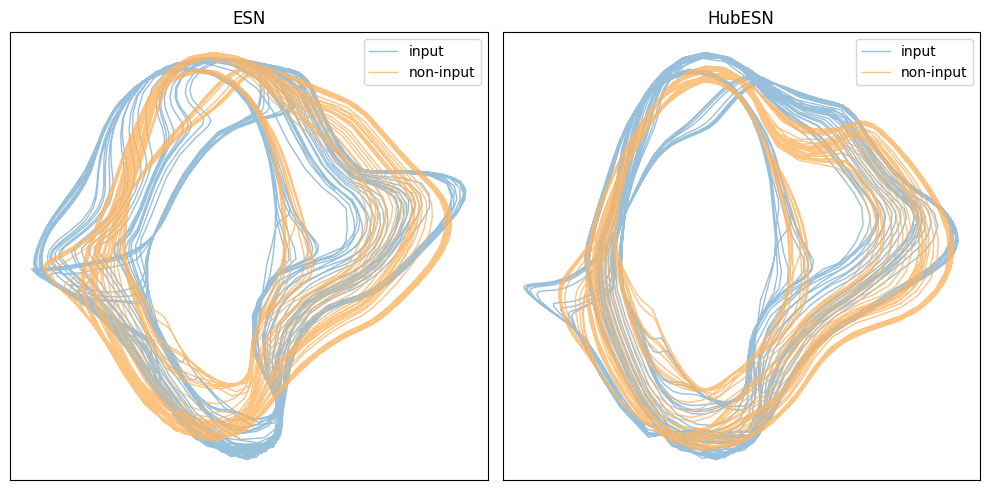

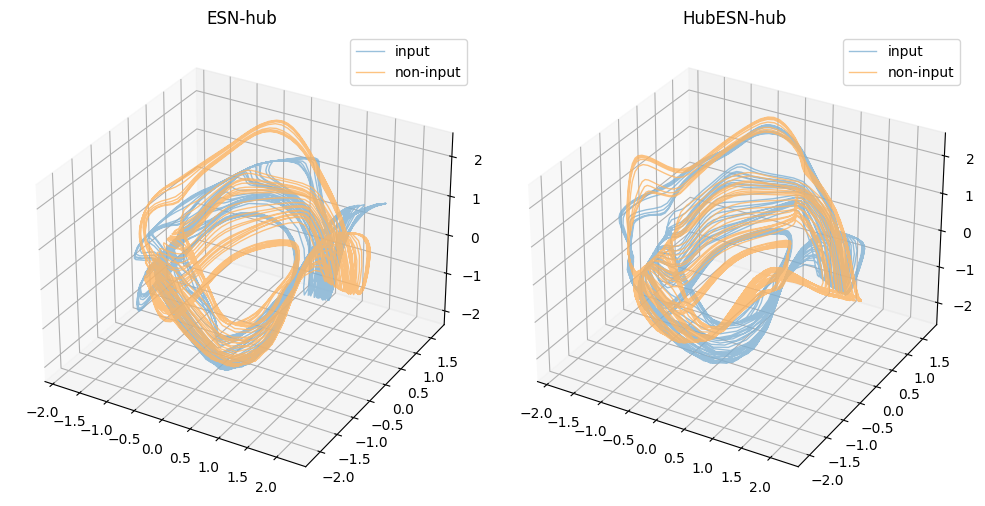

In [19]:
plot_manifold_in_nonin(hub_in_s, hub_nonin_s, esn_in_s, esn_nonin_s, method=method, display='2d')
plot_manifold_in_nonin(hub_in_s, hub_nonin_s, esn_in_s, esn_nonin_s, method=method, display='3d')

In [30]:
def get_PCA(model, task, params):
    pca = PCA(n_components=3, random_state=0)

    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)

    non_in_idx = np.array([i for i in range(esn.n_size) if i not in esn.in_idx])
    in_states = pca.fit_transform(states[:, esn.in_idx])
    nonin_states = pca.fit_transform(states[:, non_in_idx])
    # normalize so that in_states and out_states have the same scale
    in_states = StandardScaler().fit_transform(in_states)
    nonin_states = StandardScaler().fit_transform(nonin_states)

    if (in_states*nonin_states).mean() < 0:
        in_states *= -1

    return in_states[:100], nonin_states[:100]

In [85]:
def plot_delay_time(esn_delay, hubesn_delay, method='PCA'):
    xs = [0.5, 1.2]
    xlim = [0, 1.7]
    bar_width = 0.4
    alpha = 1
    colors = sns.color_palette("Set2")
    bar_color = [colors[0], colors[2]]
    font_scale = 2
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=font_scale)
    sns.set_color_codes("bright")
    plt.figure(figsize=(5, 5))
    plt.bar(xs, [esn_delay.mean(), hubesn_delay.mean()], yerr=[esn_delay.std(), hubesn_delay.std()], color=bar_color, alpha=alpha, width=bar_width, capsize=5)
    plt.xticks(xs, ['ESN', 'HubESN'])
    plt.xlim(xlim)
    plt.ylabel(f'Input-Noninput Neurons \n {method} mean-squared distance')
    plt.tight_layout()
    plt.savefig(f"{PLTPATH}/{method}_delay_time.png", dpi=300)
    plt.show()

In [9]:
def get_PCA_delay(model, task, params, n_repeat=30):
    mse = []
    for _ in range(n_repeat):
        in_s, nonin_s = get_PCA(model, task, params)
        mse.append(np.mean((in_s - nonin_s)**2))
    np.save(f"{EXPTPATH}/PCA_{model}_{task.n_train}_{params['input_neurons']}.npy", mse)

get_PCA_delay('hubesn', mg, params, n_repeat=30)
get_PCA_delay('esn', mg, params, n_repeat=30)

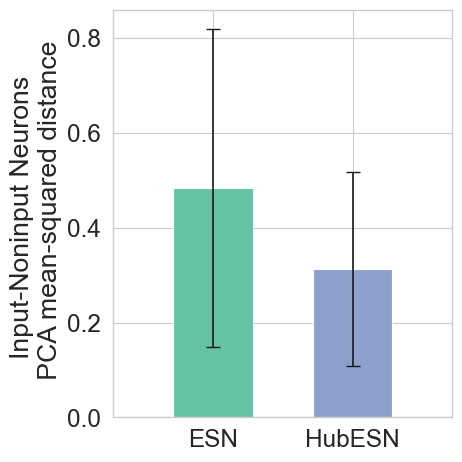

In [88]:
EXPTPATH = f"../results/info_propagation/dim_reduce_delay_{params['input_neurons']}"
n_train = 2000
input_neurons = 'hub'
esn_delay = np.load(f"{EXPTPATH}/PCA_esn_{n_train}_{input_neurons}.npy")
hubesn_delay = np.load(f"{EXPTPATH}/PCA_hubesn_{n_train}_{input_neurons}.npy")
plot_delay_time(esn_delay, hubesn_delay, method='PCA')

## tSNE

In [24]:
def get_tSNE(model, task, params):
    tsne = TSNE(n_components=3, random_state=0)

    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)

    non_in_idx = np.array([i for i in range(esn.n_size) if i not in esn.in_idx])
    in_states = tsne.fit_transform(states[:, esn.in_idx])
    nonin_states = tsne.fit_transform(states[:, non_in_idx])
    # normalize so that in_states and out_states have the same scale
    in_states = StandardScaler().fit_transform(in_states)
    nonin_states = StandardScaler().fit_transform(nonin_states)

    if (in_states*nonin_states).mean() < 0:
        in_states *= -1

    return in_states[:100], nonin_states[:100]

In [27]:
def plot_tSNE(in_s, nonin_s, params):
    lw = 2
    alpha = 1
    colors = sns.color_palette("Set3")
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(in_s[:, 0], in_s[:, 1], in_s[:, 2], color=colors[4], alpha=alpha, lw=lw, label='input')
    ax.plot(nonin_s[:, 0], nonin_s[:, 1], nonin_s[:, 2], color=colors[5], alpha=alpha, lw=lw, label='non-input')
    ax.set_title(f"HubESN-{params['input_neurons']}")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [33]:
def get_tSNE_delay(model, task, params, n_repeat=30):
    mse = []
    for _ in range(n_repeat):
        in_s, nonin_s = get_tSNE(model, task, params)
        mse.append(np.mean((in_s - nonin_s)**2))
    np.save(f"{EXPTPATH}/tSNE_{model}_{task.n_train}_{params['input_neurons']}.npy", mse)

get_tSNE_delay('hubesn', mg, params, n_repeat=30)
get_tSNE_delay('esn', mg, params, n_repeat=30)

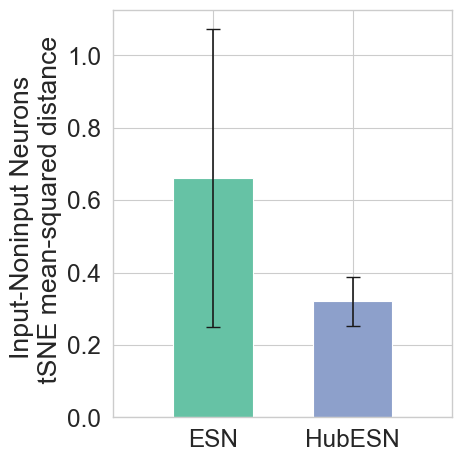

In [89]:
n_train = 2000
input_neurons = 'hub'
esn_delay = np.load(f"{EXPTPATH}/tSNE_esn_{n_train}_{input_neurons}.npy")
hubesn_delay = np.load(f"{EXPTPATH}/tSNE_hubesn_{n_train}_{input_neurons}.npy")
plot_delay_time(esn_delay, hubesn_delay, method='tSNE')

## UMAP

In [6]:
def get_UMAP(model, task, params):
    reducer = umap.UMAP(n_components=3, random_state=0)

    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)

    non_in_idx = np.array([i for i in range(esn.n_size) if i not in esn.in_idx])
    in_states = reducer.fit_transform(states[:, esn.in_idx])
    nonin_states = reducer.fit_transform(states[:, non_in_idx])
    # normalize so that in_states and out_states have the same scale
    in_states = StandardScaler().fit_transform(in_states)
    nonin_states = StandardScaler().fit_transform(nonin_states)

    if (in_states*nonin_states).mean() < 0:
        in_states *= -1

    return in_states[:100], nonin_states[:100]

In [7]:
def get_UMAP_delay(model, task, params, n_repeat=30):
    mse = []
    for _ in range(n_repeat):
        in_s, nonin_s = get_UMAP(model, task, params)
        mse.append(np.mean((in_s - nonin_s)**2))
    np.save(f"{EXPTPATH}/UMAP_{model}_{task.n_train}_{params['input_neurons']}.npy", mse)

get_UMAP_delay('hubesn', mg, params, n_repeat=30)
get_UMAP_delay('esn', mg, params, n_repeat=30)

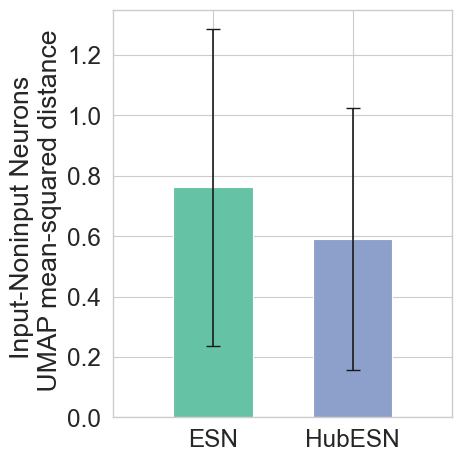

In [90]:
n_train = 2000
input_neurons = 'hub'
esn_delay = np.load(f"{EXPTPATH}/UMAP_esn_{n_train}_{input_neurons}.npy")
hubesn_delay = np.load(f"{EXPTPATH}/UMAP_hubesn_{n_train}_{input_neurons}.npy")
plot_delay_time(esn_delay, hubesn_delay, method='UMAP')